In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy
import datetime as dt
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
import os
import gc
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Read in data:
df = pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/train.csv',nrows=20_000_000, usecols=[1,2,3,4,5,6])

In [2]:
# EDA:
print(df.head())
print(df.describe())

   fare_amount          pickup_datetime  pickup_longitude  pickup_latitude  \
0          4.5  2009-06-15 17:26:21 UTC        -73.844311        40.721319   
1         16.9  2010-01-05 16:52:16 UTC        -74.016048        40.711303   
2          5.7  2011-08-18 00:35:00 UTC        -73.982738        40.761270   
3          7.7  2012-04-21 04:30:42 UTC        -73.987130        40.733143   
4          5.3  2010-03-09 07:51:00 UTC        -73.968095        40.768008   

   dropoff_longitude  dropoff_latitude  
0         -73.841610         40.712278  
1         -73.979268         40.782004  
2         -73.991242         40.750562  
3         -73.991567         40.758092  
4         -73.956655         40.783762  
        fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  2.000000e+07      2.000000e+07     2.000000e+07       1.999986e+07   
mean   1.134298e+01     -7.251140e+01     3.992070e+01      -7.251060e+01   
std    1.689916e+01      1.298955e+01     9.388927e+00

In [3]:
# Convert to type datetime:
df['pickup_datetime'] = df['pickup_datetime'].str.slice(0, 16)
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')

# Remove observations with missing values
# Since there are only a few of these, I'm not concerned with imputation
df.dropna(how='any', axis='rows', inplace=True)

# Removing observations with Lat and Long values that are not plausible
mask = df['pickup_longitude'].between(-75, -72)
mask &= df['dropoff_longitude'].between(-75, -72)
mask &= df['pickup_latitude'].between(40, 42)
mask &= df['dropoff_latitude'].between(40, 42)
# Remove outlier fare amounts
mask &= df['fare_amount'].between(0, 300)

df = df[mask]

Feature Engineering Thoughts:

-Intuitively thought that passenger count was probably negligible. I found this be true by both looking at the relationship between passenger count and fare as well as RMSE score with and without the passenger count variable when run through the model. As a result, drop this from the beginning to increase computation speed and the number of data points that can be run through the model using kaggle’s online computation tool.

-Break down pickup_datetime into as many components as possible. Broken down into hour, day, weekday, month, year.

-Distance between points. Easiest way is just taking the absolute value of the difference between pick and drop off locations for both latitude and longitude. Also learned about Haversine distance from this kernel, which proved very helpful: https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration . I ended up using the function from this kernel however https://www.kaggle.com/gunbl4d3/xgboost-ing-taxi-fares . Both haversine and the absolute value of the difference were used.

Many kernels suggested that airports drop-offs and pickups were important to distinguish because the rides had additional costs. I Initially wrote a function that spit out a Boolean value if the pick up or drop off was within a certain radius of the airport. I then found that this kernel https://www.kaggle.com/gunbl4d3/xgboost-ing-taxi-fares which instead gave the distance of the pick up or drop off to a certain point and found this superior. Not only was this great for the airports, but I realized that I could also use this to flag high traffic areas as we all know that fare increases with time and traffic increases time.


In [4]:
# Functions for feature engineering:

def dist(pickup_lat, pickup_long, dropoff_lat, dropoff_long):  
    distance = np.abs(dropoff_lat - pickup_lat) + np.abs(dropoff_long - pickup_long)
    
    return distance
    
def h_dist(pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude):
    pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude = map(np.radians, [pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude])
    dlon = dropoff_longitude - pickup_longitude
    dlat = dropoff_latitude - pickup_latitude
    a = np.sin(dlat/2.0)**2 + np.cos(pickup_latitude) * np.cos(dropoff_latitude) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = 6367 * c
    return distance
    
def transform(data):
    # Extract date attributes and then drop the pickup_datetime column
    data['hour'] = data['pickup_datetime'].dt.hour
    data['day'] = data['pickup_datetime'].dt.day
    data['weekday'] = data['pickup_datetime'].dt.weekday
    data['month'] = data['pickup_datetime'].dt.month
    data['year'] = data['pickup_datetime'].dt.year
    data = data.drop('pickup_datetime', axis=1)

    # Distances to nearby airports, and city center
    
    nyc = (-74.0063889, 40.7141667)
    jfk = (-73.7822222222, 40.6441666667)
    ewr = (-74.175, 40.69)
    lgr = (-73.87, 40.77)
    tsq = (-73.9851,40.7589)
    sol = (-74.0445,40.6892)
    cbe = (-73.8603,40.8333)
 
    data['pickup_distance_to_center'] = h_dist(nyc[1], nyc[0],
                                      data['pickup_latitude'], data['pickup_longitude'])

  
    data['pickup_distance_to_jfk'] = h_dist(jfk[1], jfk[0],
                                         data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_jfk'] = h_dist(jfk[1], jfk[0],
                                           data['dropoff_latitude'], data['dropoff_longitude'])
    data['pickup_distance_to_ewr'] = h_dist(ewr[1], ewr[0], 
                                          data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_ewr'] = h_dist(ewr[1], ewr[0],
                                           data['dropoff_latitude'], data['dropoff_longitude'])
    data['pickup_distance_to_lgr'] = h_dist(lgr[1], lgr[0],
                                          data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_lgr'] = h_dist(lgr[1], lgr[0],
                                           data['dropoff_latitude'], data['dropoff_longitude'])
    data['pickup_distance_to_tsq'] = h_dist(tsq[1], tsq[0],
                                          data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_tsq'] = h_dist(tsq[1], tsq[0],
                                           data['dropoff_latitude'], data['dropoff_longitude'])
    data['pickup_distance_to_sol'] = h_dist(sol[1], sol[0],
                                          data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_sol'] = h_dist(sol[1], sol[0],
                                           data['dropoff_latitude'], data['dropoff_longitude'])
    data['pickup_distance_to_cbe'] = h_dist(cbe[1], cbe[0],
                                          data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_cbe'] = h_dist(cbe[1], cbe[0],
                                           data['dropoff_latitude'], data['dropoff_longitude'])
    
    data['long_dist'] = data['pickup_longitude'] - data['dropoff_longitude']
    data['lat_dist'] = data['pickup_latitude'] - data['dropoff_latitude']
    
    data['dist'] = dist(data['pickup_latitude'], data['pickup_longitude'],
                        data['dropoff_latitude'], data['dropoff_longitude'])
                        
    data['h_dist'] = h_dist(data['pickup_longitude'], data['pickup_latitude'],
                        data['dropoff_longitude'], data['dropoff_latitude'])
                        
    
    
    return data

In [5]:
# use functions from above:
df_with_new_features = transform(df)

y = df_with_new_features['fare_amount']
X = df_with_new_features.drop(columns=['fare_amount'])

# Split data into training, validation, and testing sets
x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=0)


del df
del y
gc.collect()


63

In [6]:
# Hyperparameters: 
model = lgbm.LGBMRegressor(
    boosting_type='gbdt',
    objective='regression',
    n_jobs=4,
    num_leaves=31,
    learning_rate=0.1,
    max_depth=-1,
    subsample=0.8,
    bagging_fraction=1,
    max_bin=5000,
    bagging_freq=20,
    colsample_bytree=0.6,
    metric='rmse',
    min_split_gain=0.5,
    min_child_weight=1,
    min_child_samples=10,
    scale_pos_weight=1,
    zero_as_missing=True,
    seed=0,
    n_estimators=10000
)


#train_set = lgbm.Dataset(x_train, y_train,categorical_feature=['year','month','weekday','day'])
#valid_set = lgbm.Dataset(x_test, y_test,categorical_feature=['year','month','weekday','day'])
model.fit(
    x_train, y_train,
    eval_set=[(x_val, y_val)],
    eval_metric='rmse'
)

[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.888604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 105084
[LightGBM] [Info] Number of data points in the train set: 13704637, number of used features: 26
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Info] Start training from

LGBMRegressor(bagging_fraction=1, bagging_freq=20, colsample_bytree=0.6,
              max_bin=5000, metric='rmse', min_child_samples=10,
              min_child_weight=1, min_split_gain=0.5, n_estimators=10000,
              n_jobs=4, objective='regression', scale_pos_weight=1, seed=0,
              subsample=0.8, zero_as_missing=True)

In [7]:
# Calculate performance metrics
test_pred = model.predict(x_test) 
rmse = np.sqrt(mean_squared_error(y_test, test_pred))
mae = mean_absolute_error(y_test, test_pred)
r2 = r2_score(y_test, test_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R-squared: {r2}')


[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
RMSE: 3.448263588708533
MAE: 1.4756200534531714
R-squared: 0.8725202408929745


Model Thoughts:

-As I didn’t want to spend any money on computing time I limited myself to only using Kaggle's free cloud computing. This is limiting because you have memory and time restrictions.

-I started by using a random forest as I had used this in another project before and had marginal results. I then started experimenting with  XGBoost, this kernel was very helpful. https://www.kaggle.com/gunbl4d3/xgboost-ing-taxi-fares. I saw some good improvement, but was limited to only running about 4 million records of the 55 million available. Finally, I stumbled upon this kernel which introduced me to LGBM https://www.kaggle.com/jsylas/python-version-of-top-ten-rank-r-22-m-2-88. This allowed me to run 22-25 million records depending on how many variables I had.



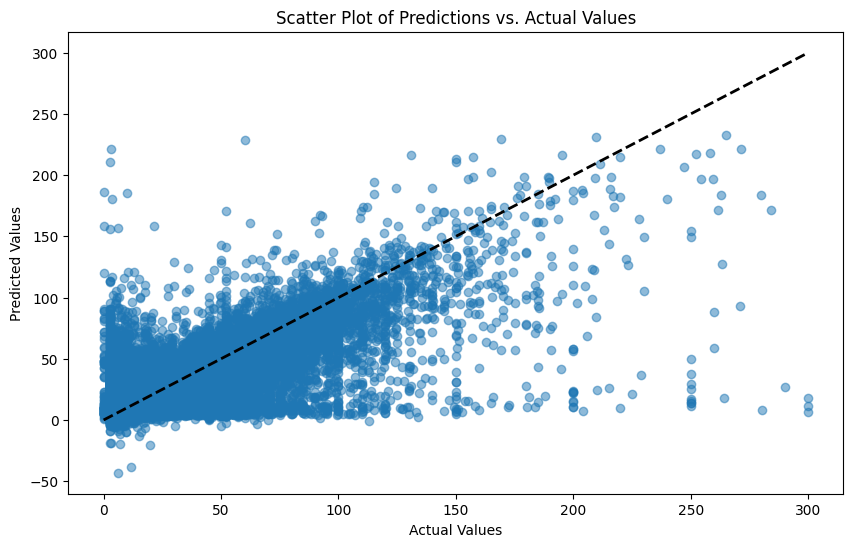

In [9]:
# Scatter Plot of Predictions vs. Actual Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Predictions vs. Actual Values')
plt.show()

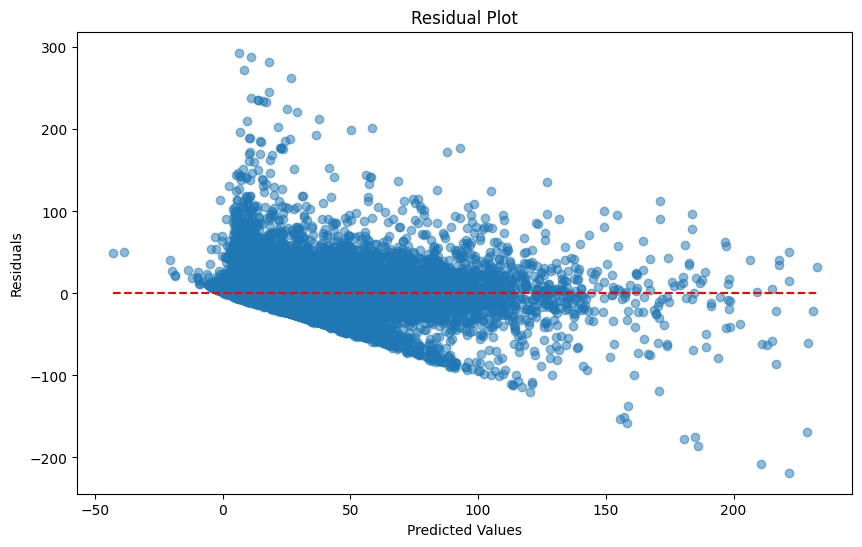

In [10]:
# Residual Plot
residuals = y_test - test_pred
plt.figure(figsize=(10, 6))
plt.scatter(test_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=test_pred.min(), xmax=test_pred.max(), colors='r', linestyles='dashed')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [8]:
# This is all the code nessesary for sumbiting to the kaggle comp.
# They dont proivde the label ( fare amount) in this data set else people could cheat in the competition. 
# Read in the testing set
test_df =  pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/test.csv')

# Clean up the test set in the same way we did for the training set.
test_df['pickup_datetime'] = test_df['pickup_datetime'].str.slice(0, 16)
test_df['pickup_datetime'] = pd.to_datetime(test_df['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
test_df = transform(test_df)
                                                                    
test_key = test_df['key']
test_df = test_df.drop(columns=['key','passenger_count'])

# Make predictions on the test set:
prediction = model.predict(test_df)      
submission = pd.DataFrame({
        "key": test_key,
        "fare_amount": prediction
})


# export as CSV:
submission.to_csv('submission.csv',index=False)

[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
